In [ ]:
import sys
!{sys.executable} -m pip install PyAstronomy

In [1]:
from PyAstronomy.pyasl import foldAt
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
import numpy as np
from astropy.timeseries import LombScargle
import pandas as pd
import scipy.optimize as opt
from scipy.interpolate import interp1d

In [2]:
def period_fold(t, y, yerr, freq):
    """
    Period fold a time series given the time, flux, uncertainty, and the frequency to fold at.
    If np = False, it will also plot the phase folded graph.
    """

    phases = foldAt(t, 1/freq, T0 = t[0]) # Use the PyAstronomy function to get the phases each time stamp is at
    # print(phases)
    sortIndi = np.argsort(phases) # Get the indices that would sort the phases in increasing order (from 0 to 1)
    phases = phases[sortIndi] # Get the phases at the sorted indices.
    y = y[sortIndi] # Get the fluxes at the sorted indices
    
    # if np == False:
        # If np == False, plot the results.
    plt.errorbar(phases, y, yerr, fmt = "k.")
    plt.title("Frequency: " + str(freq) + ", Period: " + str(1/freq))
    plt.show()
    
    # Return the phases and their associated fluxes.
    return phases, y


def identify_peaks(ls, frequency, power, n=20):
    """
    Finds the top n peaks in a periodogram given the LombScargle object, frequency list, and 
    power list. Returns the top n frequencies, powers, and their associated false alarm probability
    (I should probably make this optional).
    """
    
    maxes = [np.where(power==sorted(power, reverse=True)[i]) for i in range(n)] # Find the indexes where power is sorted maximum to minimum.
    
    best_freqs = []
    powers = []
    faps = []
    
    for i in range(len(maxes)):
        # find the power and frequency at the max indices
        p_ = power[maxes[i][0][0]] 
        f_ = frequency[maxes[i][0][0]]
        best_freqs.append(f_)
        powers.append(p_)
        # faps.append(ls.false_alarm_probability(p_)) # also finds the FAP at the peak.
        
    return best_freqs, powers
        

In [3]:
def max_peaks(frequency, power, n):
    """
    Finds the top n peaks in a periodogram given the LombScargle object, frequency list, and 
    power list. Returns the top n frequencies (todo: why do we need this function?)
    """
    maxes = [np.where(power==sorted(power, reverse=True)[i]) for i in range(n)]
    best_freqs = [frequency[maxes[i][0][0]] for i in range(len(maxes)-1)]
    
    return best_freqs

def simple_a(t, A, B, w, phi): 
    """
    A sin model, where y = Asin(wt + phi) + B.
    """
    return B + A * np.sin(w*t + phi)

def fit_sin(t, flux, est_pars=[], enforce_A=False, np = False):  
    """
    Given the time, flux, and estimated parameters, fits a sine function with simple_a.
    todo: Figure out how to improve accuracy
    """
    if est_pars == []:
        # If no estimated parameters are given, set the frequeny to the highest peak in its Lomb Scargle periodogram,
        # Set the estimated amplitude to the range of fluxes divided by 2, the B value to the average flux, and the phi value to 0.
        frequency, power = LombScargle(t, flux).autopower()
        w = frequency[np.argmax(power)]
        est_pars = [(max(flux)-min(flux))/2, np.average(flux), w, 0]
        
    
    oscillator_model = simple_a

    start_time=0 # todo: shouldn't be hard coded
    tvals = np.linspace(t[0], t[len(t)-1],num=1000)  
    start_pars= est_pars
    
    pars, cov = opt.curve_fit(oscillator_model, t-start_time, flux, p0=start_pars) # Fit the model given the estimated parameters

    [A, B, w, phi] = pars
    print(pars)
    
    if enforce_A==True:
        A = est_pars[0] # Set the amplitude to the first of the estimated parameters if you wish to enforce 
        # (because the A seems to be getting underestimated in the analysis)

    ypred = oscillator_model(tvals-start_time, A, B, w, phi)
    
    if np == False:

        # Data and fit
        plt.scatter(t, flux)
        plt.plot(tvals, ypred, color='orange')

        # Axes label and title
        plt.title("Best Sine Fit")
        plt.xlabel("Time")
        plt.ylabel("Flux")

        plt.show()
    
    return tvals, ypred, pars

In [4]:
def residuals(y, ypred):
    return y-ypred

def variance(y):
    return np.var(y)

def refined_fit(t, flux, best_freq):
    """
    Performs a period folding then sine fit on the frequencies near the input. Returns the 
    frequency with the least variance in residuals. Probably really slow because it's probing 
    100 frequences...
    """
    #Make a frequency grid
    freq_grid = np.linspace(best_freq-0.1, best_freq+0.1, 20)
    variance_ = (0,np.inf)
    best_fit = []
    period_folded = []
    pars_ = []
    
    #Period fold for each frequency
    for f in freq_grid:
        t_phase, f_phase = period_fold(t, flux, f, np = True)
        
        #Fit a sine curve for each folded dataset
        try:
            tvals, fpred, pars = fit_sin(t_phase, f_phase, est_pars = [(max(f_phase)-min(f_phase))/2, np.average(f_phase), f, 0], np = True)
            fpred = simple_a(t_phase, *pars)
            #Update the residuals variance list with the frequency and variance
            var = variance(residuals(f_phase, fpred).values)
            if var < variance_[1]:
                variance_ = (f, var)
                best_fit = [tvals, simple_a(tvals, *pars)]
                period_folded = [t_phase, f_phase]
                pars_ = pars
        except RuntimeError:
           print("unable to fit data for frequency: " + str(f))
    tvals = np.linspace(period_folded[0][0], period_folded[0][len(t)-1], 100)
    plt.scatter(period_folded[0], period_folded[1])
    plt.plot(tvals, simple_a(tvals, *pars_))
    plt.xlabel("Time (Phase)")
    plt.ylabel("Flux")
    plt.title("Period Folded Graph\nFrequency: " + str(variance_[0]) + " Hz, Variance: " + str(variance_[1]))
    #return the frequency with the minimum residuals variance
    return variance_, best_fit, period_folded, pars_


In [5]:
"""
ROUTINE FOR DATA EXPLORATION

0. Get candidate data from webscraper and save it to a csv.
1. Run a periodogram. Check for large peaks manually. Select top 5 peaks with FAP <0.001
2. Perform period folding, raw file fits, and residual/variance calculations based on the peak frequencies.
3. Select the best fit based on (2).
"""

'\nROUTINE FOR DATA EXPLORATION\n\n0. Get candidate data from webscraper and save it to a csv.\n1. Run a periodogram. Check for large peaks manually. Select top 5 peaks with FAP <0.001\n2. Perform period folding, raw file fits, and residual/variance calculations based on the peak frequencies.\n3. Select the best fit based on (2).\n'

In [8]:
def get_band_ts(df, band):
    """
    returns the DataFrame Series for time, flux, and uncertainity given the formatted DataFrame. 
    The DataFrame must be formatted to have "band title" for every column, such as "g BJD" or "z dy"
    """
    return df[band + " BJD"], df[band + " Flux"], df[band + " dy"]

bands = ["g", "r", "i", "z"]
candidate = "DC21badcl"
df = pd.read_csv("data/" + candidate + ".csv")

#print(df)

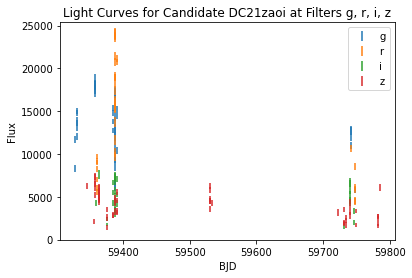

In [9]:
#Plot the light curves from different bands on top of each other
for b in bands:
    plt.errorbar(get_band_ts(df, b)[0], get_band_ts(df, b)[1], yerr = get_band_ts(df, b)[2], label = b, ls='none')
plt.title("Light Curves for Candidate DC21zaoi at Filters g, r, i, z")
plt.xlabel("BJD")
plt.ylabel("Flux")
plt.legend()

In [10]:
"""
Select the maximum peaks, their powers, and FAPs. For some reason very low FAPs have nan values, which is something
I should look into. 
"""
def period_fold(t, y, freq):

    phases = foldAt(t, period=1/freq)
    print(phases.max())
    sortIndi = np.argsort(phases)
    phases = phases[sortIndi]
    y = y[sortIndi]

    plt.plot(phases,y, 'bp')
    # plt.plot(t_fit, np.sin(t_fit*best_frequency))
    plt.title("Frequency: " + str(freq) + ", Period: " + str(1/freq))
    plt.show()
    
    return phases, y

In [11]:
def fit_peaks(p, t, f, df, lsg):
    phases = foldAt(t, p)
    print("PERIOD: ", p)

    sortIndi = np.argsort(phases)

    phases = phases[sortIndi]
    fg1 = f[sortIndi]

    plt.errorbar(phases, fg1, yerr = df, fmt = "k.")

    t_fit = np.linspace(0, p, 100)
    y_fit = lsg.model(t_fit, 1/p)

    plt.plot(t_fit/p, y_fit)
    plt.xlabel("Phase"), plt.ylabel("Flux")
    plt.title("Phase Folded Best Fit at Period " + str(round(p, 3)))
    # plt.xlim(0, 0.7)
    plt.show()

    y_fit = lsg.model(t, 1/p)
    # var.append(variance(fg-y_fit))

    print(variance(f-y_fit))

    plt.show()

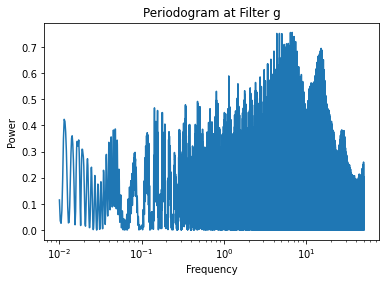

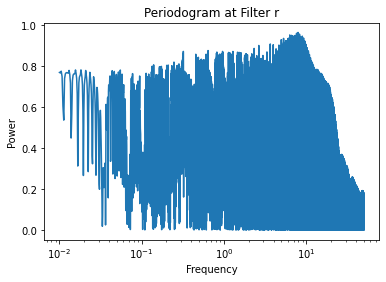

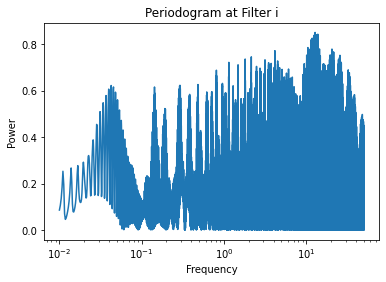

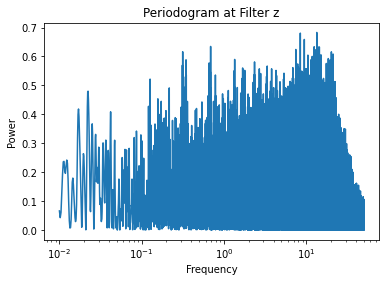

In [13]:
# Plot the periodograms for each band 

for b in bands:
    tr, fr, dy = get_band_ts(df, b)
    tr = tr.dropna()
    # print(len(tr))
    
    tr = tr.dropna()
    fr = fr.dropna()
    dy = dy.dropna()

    lsr = LombScargle(tr, fr, dy)
    freqg, pg = lsr.autopower(minimum_frequency=0.01, maximum_frequency=50, samples_per_peak=10)
    pg = abs(pg)
    plt.plot(freqg, pg, label=b)
    plt.title("Periodogram at Filter " + b)
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xscale("log")
    
    plt.show()

In [14]:
"""
FAP ANALYSIS
1. Find all signals with FAPs less than 0.001
2. Graph them as axis lines.
3. Phase fold the signal with the highest FAP for each 0.5 day bin as long as the FAP is below 0.001.
"""

'\nFAP ANALYSIS\n1. Find all signals with FAPs less than 0.001\n2. Graph them as axis lines.\n3. Phase fold the signal with the highest FAP for each 0.5 day bin as long as the FAP is below 0.001.\n'

66


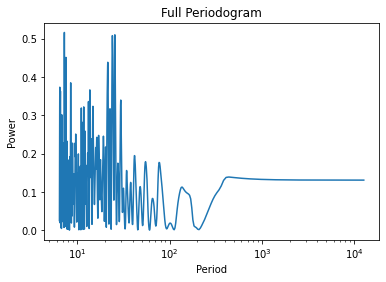

7.246807524439348
0.5166211329522854
1.5107081680497536e-07


In [15]:
# Finding all signals with FAPs less than 0.001 in the g band

def get_band_ts(df, band):
    return df[band + " BJD"], df[band + " Flux"], df[band + " dy"]

bands = ["g", "r", "i", "z"]
df = pd.read_csv("data/DC21zaoi.csv")

"""
LOOK AT G BAND

Plot raw light curve and periodogram
because I am doing multiple bands, I am trying to keep the variable names seperate to prevent any overlap.
"""

band = "z"
tg, fg, dg = get_band_ts(df, band)

tg = tg.dropna()
fg = fg.dropna()
dg = dg.dropna()

print(len(tg))

lsg = LombScargle(tg, fg, dg, nterms=1)
#frequency, power = lsg.autopower(minimum_frequency=0.01, maximum_frequency=50, samples_per_peak=15)
frequency, power = lsg.autopower(nyquist_factor=2, samples_per_peak=15)
power = abs(power)
plt.plot(1/frequency, power)
plt.title("Full Periodogram")
plt.xlabel("Period")
plt.ylabel("Power")
plt.xscale('log')
plt.show()

print(1/frequency[np.argmax(power)])
print(power[np.argmax(power)])
print(lsg.false_alarm_probability(power[np.argmax(power)]))
bfg, bpg = identify_peaks(lsg, frequency = frequency, power = power)
# print(1/np.array(bfg))

PERIOD:  0.0802226960659027


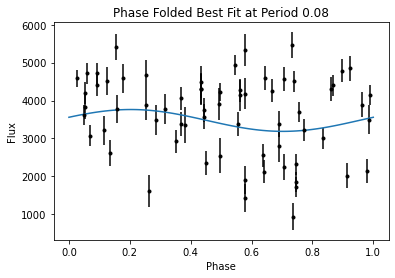

1054684.748363229
PERIOD:  3.124023914337158


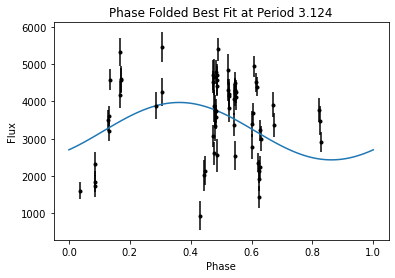

1005234.9069297374
PERIOD:  0.0781304910778999


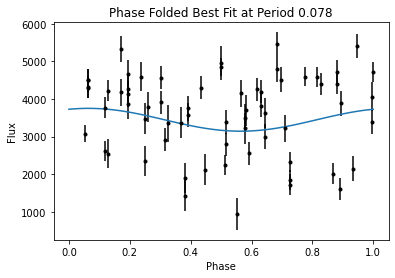

1055417.449588737
PERIOD:  0.105617806315422


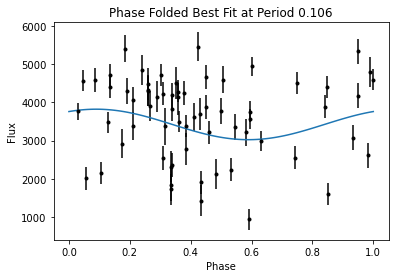

1040431.8316915504
PERIOD:  0.377943217754364


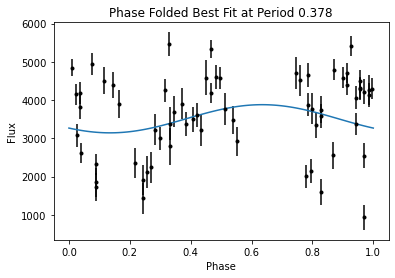

1070564.537758753
PERIOD:  0.2471027374267578


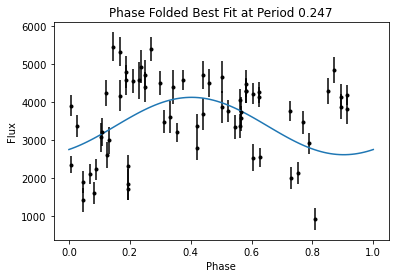

1000511.8364821137
PERIOD:  0.2026383578777313


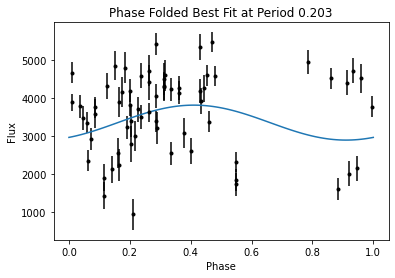

1088242.0173469845
PERIOD:  0.0781134068965911


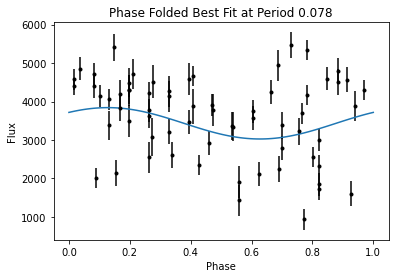

1008160.6576376443
PERIOD:  0.2119497209787368


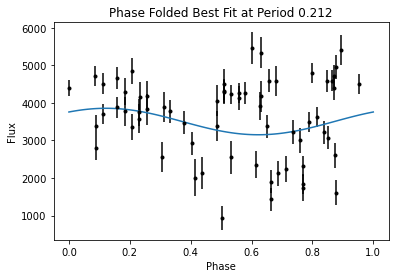

1058016.2416634033
PERIOD:  0.2119463976581632


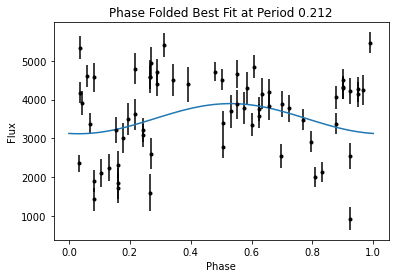

1051482.6934777142
PERIOD:  0.1587326824665069


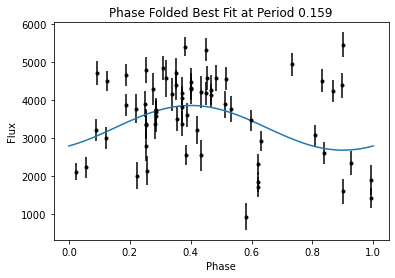

1003813.0887961837
PERIOD:  0.1979315532945085


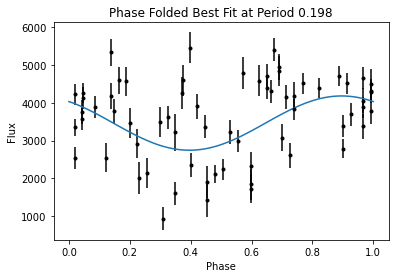

945761.6068298644
PERIOD:  0.1258526444435119


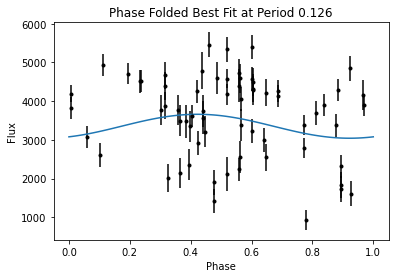

1085557.9175051572
PERIOD:  0.1562255918979644


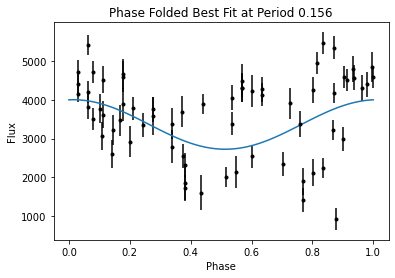

945970.1042993078
PERIOD:  0.1181302840715888


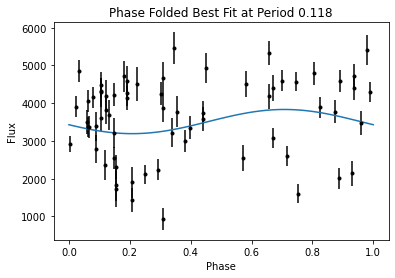

1074385.2233354175
PERIOD:  0.1509889811277389


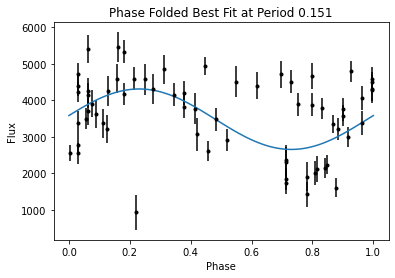

914009.0663616465
PERIOD:  0.1311819404363632


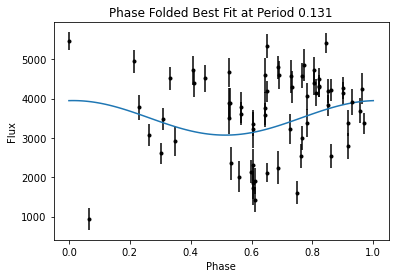

1058222.757585839
PERIOD:  0.2959805727005005


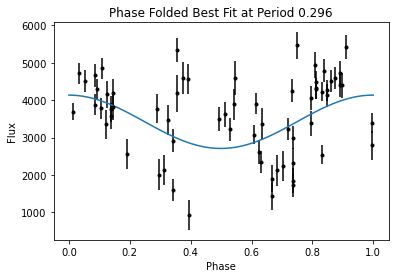

935664.47840943
PERIOD:  0.211233377456665


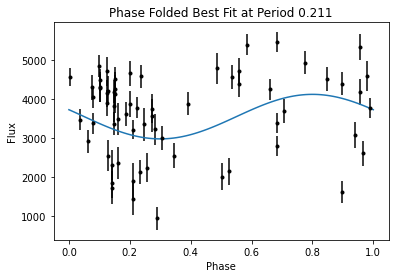

999754.8338022096
PERIOD:  0.2517052888870239


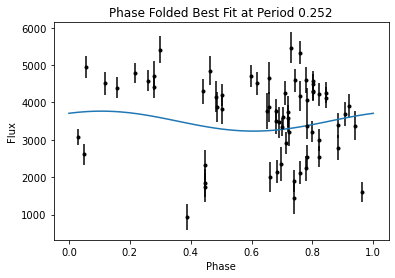

1090180.674754639


In [16]:
# best_frequency = frequency[np.argmax(power)]
# print(len(tg))
# best_freqs, powers = identify_peaks(lsg, frequency, power, n = 5)
# # phases, y = period_fold(tg, fg, dg, best_freqs[1]/4)
# fit_peaks(1/(best_freqs[1]), tg, fg, dg, lsg)
# for freq in best_freqs:
#     # phases, y = period_fold(tg, fg, dg, freq)
#     fit_peaks(1/freq, tg, fg, dg, lsg)

periods = pd.read_csv("data/periodsz.csv")

for freq in periods["z"]:
    # phases, y = period_fold(tg, fg, dg, freq)
    fit_peaks(freq, tg, fg, dg, lsg)

0 991


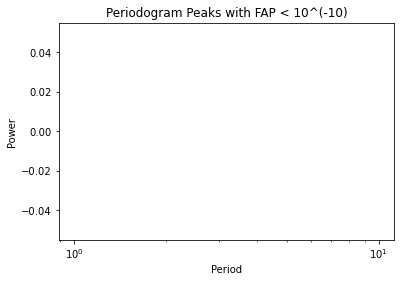

In [113]:
# Find all peaks with FAP < 0.001

fap = [lsg.false_alarm_probability(i) for i in power]
best_peaks = {"Frequency": [], "Power": [], "FAP": []}

for i in range(len(fap)):
    if fap[i] < 10**(-9):
        best_peaks["Frequency"].append(frequency[i])
        best_peaks["Power"].append(power[i])
        best_peaks["FAP"].append(fap[i])

print(len(best_peaks["Frequency"]), len(frequency))
# print(fap)
plt.plot(1/np.array(best_peaks["Frequency"]), best_peaks["Power"])
plt.title("Periodogram Peaks with FAP < 10^(-10)")
plt.xlabel("Period")
plt.ylabel("Power")
plt.xscale('log')
plt.show()

# print(best_peaks["Frequency"])

In [114]:
# Find the max frequency for each 0.5 day bin using scipy.binned_statistic

from scipy import stats

# bins = np.linspace(0.5, 100, num=201)
print(max(best_peaks["Frequency"]), min(best_peaks["Frequency"]))
print(1/max(best_peaks["Frequency"]), 1/min(best_peaks["Frequency"]))

bin_maxes, bin_edges, binnumber = stats.binned_statistic(best_peaks["Frequency"], best_peaks["Power"], statistic= "max", bins=201)

indices = [best_peaks["Power"].index(i) for i in bin_maxes[~np.isnan(bin_maxes)]]
binned_peaks = (pd.DataFrame(best_peaks).iloc[indices]).reset_index()
# print(binned_peaks)

ValueError: max() arg is an empty sequence

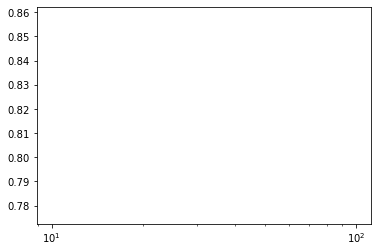

In [115]:
plt.plot(1/np.array(binned_peaks["Frequency"]), binned_peaks["Power"])
plt.xscale("log")

In [116]:
# Retest this later with 30 minute bins from 0 to 10 days

# Period folding at each of these peaks
periods = 1/binned_peaks["Frequency"]
binned_peaks["Period"] = periods
var = []

for p in periods:
    phases = foldAt(tg, p)
    # print("PERIOD: ", p)

    sortIndi = np.argsort(phases)

    phases = phases[sortIndi]
    fg1 = fg[sortIndi]

    # plt.errorbar(phases, fg1, yerr = dg, fmt = "k.")

    t_fit = np.linspace(0, p, 100)
    y_fit = lsg.model(t_fit, 1/p)

    # plt.plot(t_fit/p, y_fit)
    # plt.xlabel("Phase"), plt.ylabel("Flux")
    # plt.title("Phase Folded Best Fit at Period " + str(round(p, 3)))
    # plt.xlim(0, 0.7)
    # plt.show()

    y_fit = lsg.model(tg, 1/p)
    var.append(variance(fg-y_fit))
    
    # print(variance(fg-y_fit))

    # plt.show()
    
binned_peaks["Variance"] = var

In [117]:
#binned_peaks = binned_peaks.reset_index()

print(binned_peaks.idxmin())

best_fit = binned_peaks.iloc[binned_peaks.idxmin()[5]]

index        0
Frequency    0
Power        0
FAP          0
Period       0
Variance     0
dtype: int64


In [118]:
def fit_peaks(p, tg, fg, dg, lsg):
    phases = foldAt(tg, p)
    print("PERIOD: ", p)

    sortIndi = np.argsort(phases)

    phases = phases[sortIndi]
    fg1 = fg[sortIndi]

    plt.errorbar(phases, fg1, yerr = dg, fmt = "k.")

    t_fit = np.linspace(0, p, 100)
    y_fit = lsg.model(t_fit, 1/p)

    plt.plot(t_fit/p, y_fit)
    plt.xlabel("Phase"), plt.ylabel("Flux")
    plt.title("Phase Folded Best Fit at Period " + str(round(p, 3)))
    # plt.xlim(0, 0.7)
    plt.show()

    y_fit = lsg.model(tg, 1/p)
    # var.append(variance(fg-y_fit))

    print(variance(fg-y_fit))

    plt.show()

PERIOD:  21.820894206568724


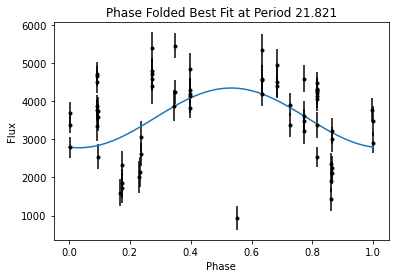

973926.7895569401


In [119]:
p = best_fit["Period"]

phases = foldAt(tg, p)
print("PERIOD: ", p)

sortIndi = np.argsort(phases)

phases = phases[sortIndi]
fg1 = fg[sortIndi]

plt.errorbar(phases, fg1, yerr = dg, fmt = "k.")

t_fit = np.linspace(0, p, 100)
y_fit = lsg.model(t_fit, 1/p)

plt.plot(t_fit/p, y_fit)
plt.xlabel("Phase"), plt.ylabel("Flux")
plt.title("Phase Folded Best Fit at Period " + str(round(p, 3)))
# plt.xlim(0, 0.7)
plt.show()

y_fit = lsg.model(tg, 1/p)
var.append(variance(fg-y_fit))

print(variance(fg-y_fit))

plt.show()

index        0.000000e+00
Frequency    4.582764e-02
Power        8.173513e-01
FAP          9.727094e-10
Period       2.182089e+01
Variance     9.739268e+05
Name: 0, dtype: float64
PERIOD:  21.820894206568724


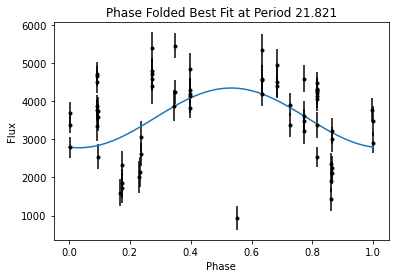

973926.7895569401


In [120]:
best_fit_fap = binned_peaks.iloc[binned_peaks.idxmin()[3]]
print(best_fit_fap)
p = best_fit_fap["Period"]
#p = 0.22

fit_peaks(p, tg, fg, dg, lsg)

0.8173513159491076
0.5166211329522854


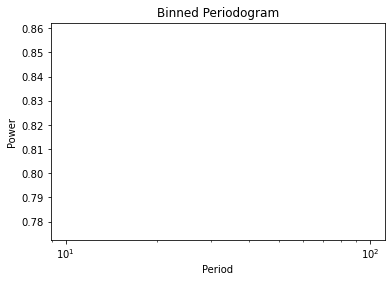

Text(0.5, 1.0, 'Full Periodogram')

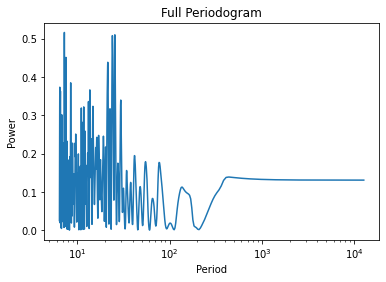

In [121]:
plt.plot(1/binned_peaks["Frequency"], binned_peaks["Power"])
print(max(list(binned_peaks["Power"])))
print(max(list(power)))
#plt.axvline(0.645, color="red")
#plt.axvline(0.2195, color="green")
plt.xlabel("Period")
plt.ylabel("Power")
plt.title("Binned Periodogram")
plt.xscale('log')
# plt.xlim(0, 1)
plt.show()

plt.plot(1/frequency, power)
plt.xscale('log')
plt.xlabel("Period")
plt.ylabel("Power")
plt.title("Full Periodogram")
#plt.axvline(0.645, color="red")
#plt.axvline(0.2195, color="green")
# plt.xlim(0, 1)

index        0.000000e+00
Frequency    4.582764e-02
Power        8.173513e-01
FAP          9.727094e-10
Period       2.182089e+01
Variance     9.739268e+05
Name: 0, dtype: float64
PERIOD:  21.820894206568724


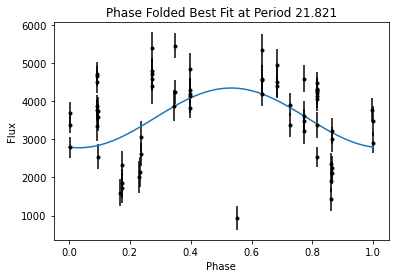

973926.7895569401


In [122]:
best_fit_fap = binned_peaks.iloc[binned_peaks.idxmin()[3]]
print(best_fit_fap)
p = best_fit_fap["Period"]
# p = 0.21954700125452684

fit_peaks(p, tg, fg, dg, lsg)

In [123]:
index = list(power).index(max(power))
print(1/frequency[index], power[index])

index = list(binned_peaks["Power"]).index(max(binned_peaks["Power"]))
print(binned_peaks["Period"][index], binned_peaks["Power"][index])

print(best_fit["Period"], best_fit["Power"])

7.246807524439348 0.5166211329522854
21.820894206568724 0.8173513159491076
21.820894206568724 0.8173513159491076


In [124]:
"""
BEST PERIODS:
g band, p = 0.6453082759220174, 0.21954700125452684
r band, p = 0.2647498899909206, 0.28950483246532827
i band, p = 0.18491172513011217, 0.22675354712842896
z band, p = 2.698277420351543, 0.5761857638328277

BEST PERIODS DC22 CAND 2:
g band, p = nan
r band, p = 0.12083458042153733, 0.1374925402361324
i band, p = 0.10771995653812375
z band, p = nan

BEST PERIODS DC21badcl:
g band, p = 8.420807179457475
r band, p = 15.584923659524943, 13.838817790638954
i band, p = 21.820894206568724
z band, p = nan
"""
periods = [8.420807179457475, 15.584923659524943, 13.838817790638954, 21.820894206568724]

[0.0802227  3.12402391 0.07813049 0.10561781 0.37794322 0.24710274
 0.20263836 0.07811341 0.21194972 0.2119464  0.15873268 0.19793155
 0.12585264 0.15622559 0.11813028 0.15098898 0.13118194 0.29598057
 0.21123338 0.25170529]
88
STARTING FIT FOR BAND: g
PERIOD:  0.0802226960659027


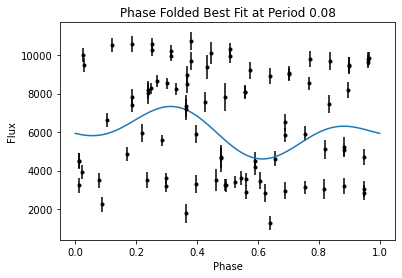

7057447.9749666685
PERIOD:  3.124023914337158


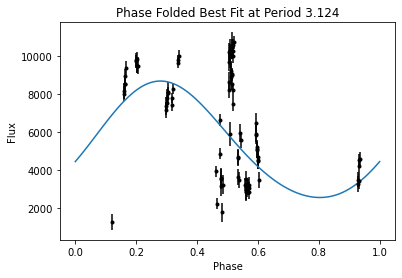

5545118.130456424
PERIOD:  0.0781304910778999


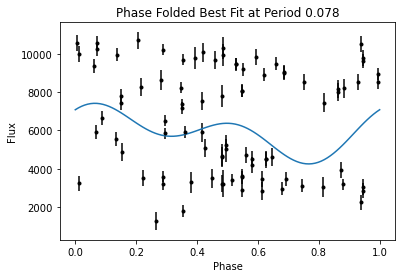

7307758.1897394005
PERIOD:  0.105617806315422


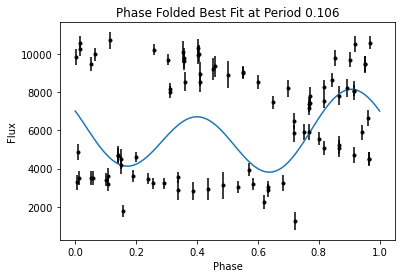

6469666.433878341
PERIOD:  0.377943217754364


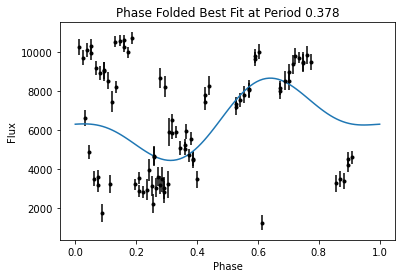

5876806.740593234
PERIOD:  0.2471027374267578


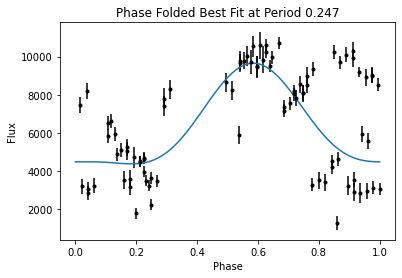

4589544.105461412
PERIOD:  0.2026383578777313


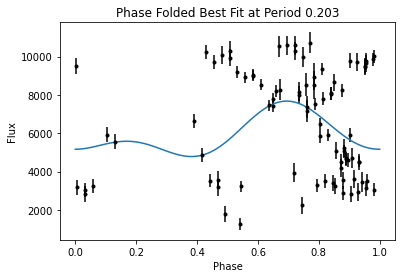

6911725.7041794965
PERIOD:  0.0781134068965911


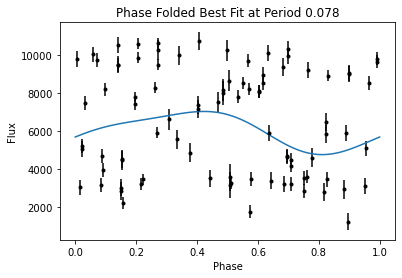

7309831.368514661
PERIOD:  0.2119497209787368


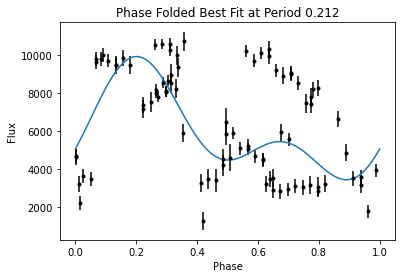

5018921.522070632
PERIOD:  0.2119463976581632


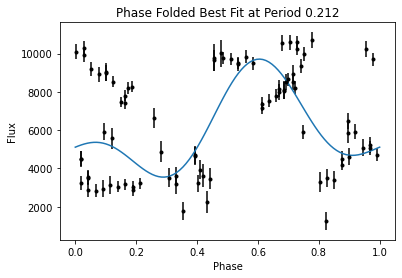

5282819.797798196
PERIOD:  0.1587326824665069


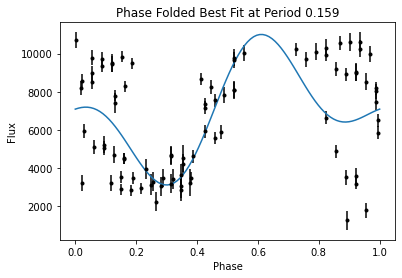

4778658.221343543
PERIOD:  0.1979315532945085


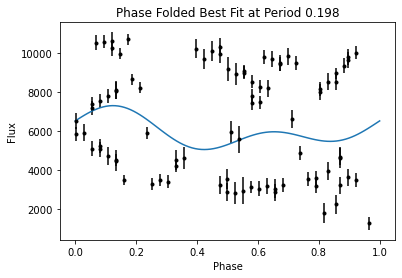

7654974.1328555085
PERIOD:  0.1258526444435119


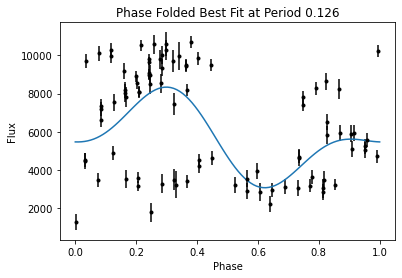

5512667.459666461
PERIOD:  0.1562255918979644


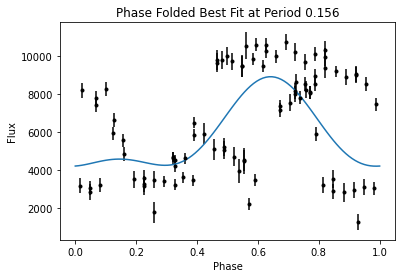

5482537.943913955
PERIOD:  0.1181302840715888


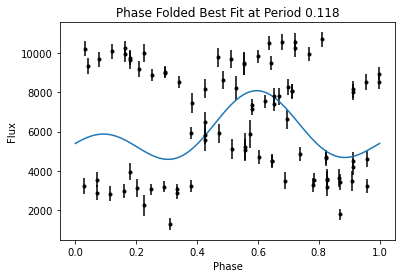

7056776.99900788
PERIOD:  0.1509889811277389


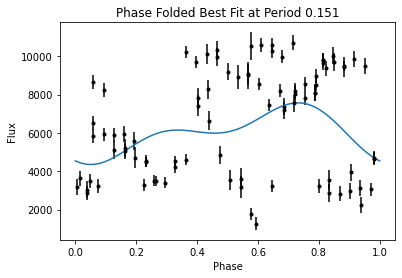

6324446.431964613
PERIOD:  0.1311819404363632


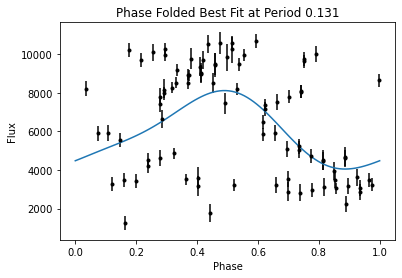

5552672.796297331
PERIOD:  0.2959805727005005


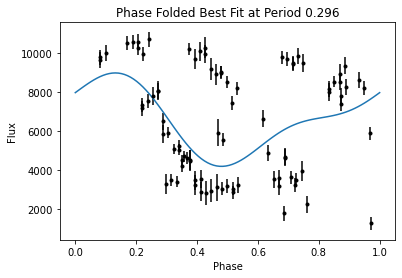

6663390.410398648
PERIOD:  0.211233377456665


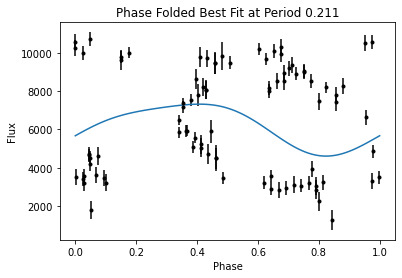

7841168.9778686855
PERIOD:  0.2517052888870239


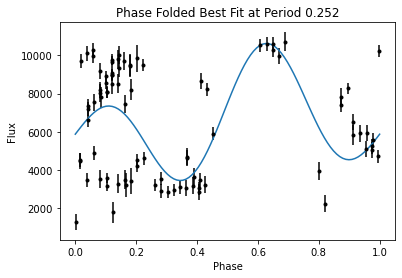

5048858.751492322
88
STARTING FIT FOR BAND: r
PERIOD:  0.0802226960659027


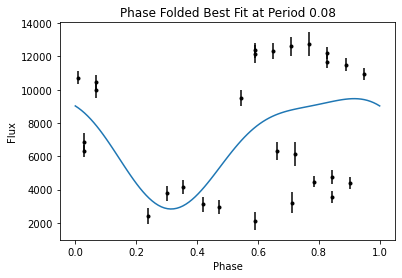

11408605.081194896
PERIOD:  3.124023914337158


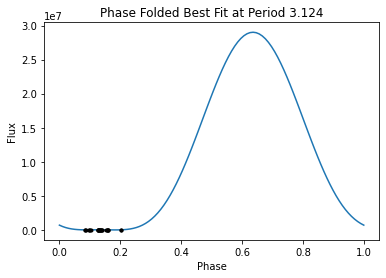

934386.0303309935
PERIOD:  0.0781304910778999


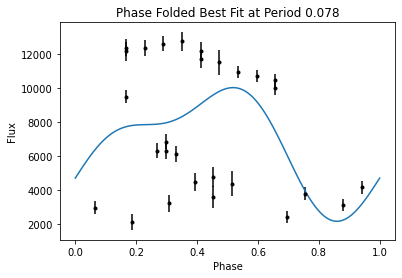

12352326.720416417
PERIOD:  0.105617806315422


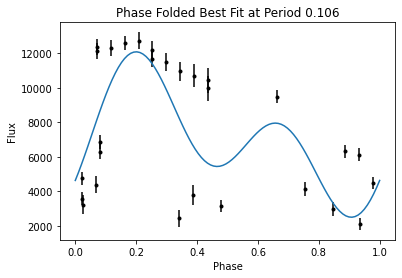

7821169.673877577
PERIOD:  0.377943217754364


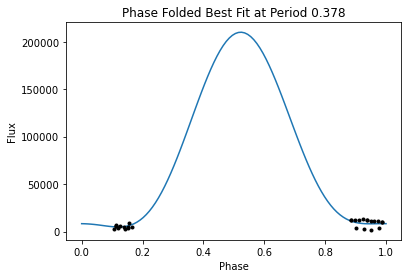

9627832.234364888
PERIOD:  0.2471027374267578


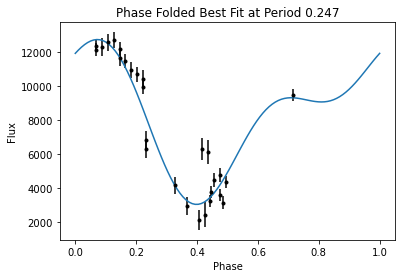

1288490.0087647948
PERIOD:  0.2026383578777313


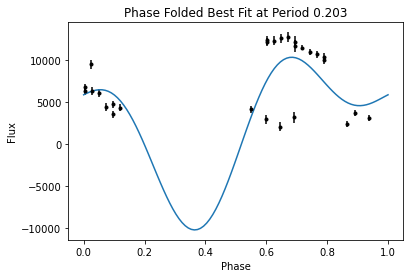

9364770.94191931
PERIOD:  0.0781134068965911


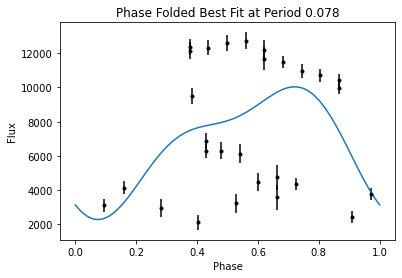

12484343.830679134
PERIOD:  0.2119497209787368


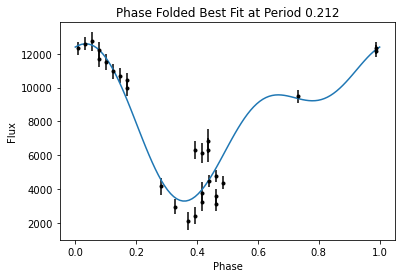

1331741.1435955802
PERIOD:  0.2119463976581632


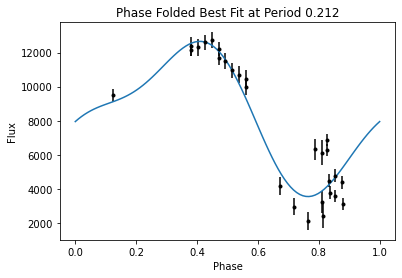

1441522.3228316035
PERIOD:  0.1587326824665069


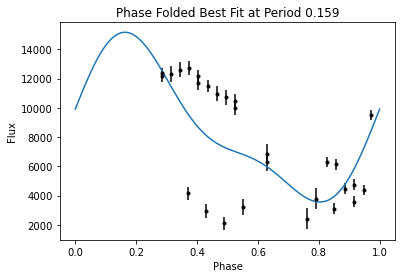

7824704.243244643
PERIOD:  0.1979315532945085


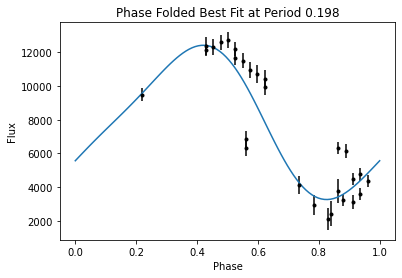

2248599.720117702
PERIOD:  0.1258526444435119


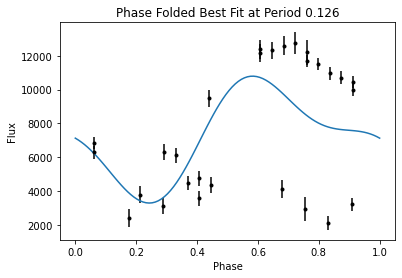

9275527.712945798
PERIOD:  0.1562255918979644


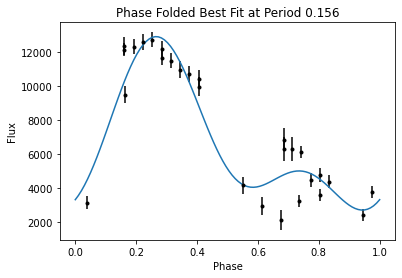

1452030.5187104116
PERIOD:  0.1181302840715888


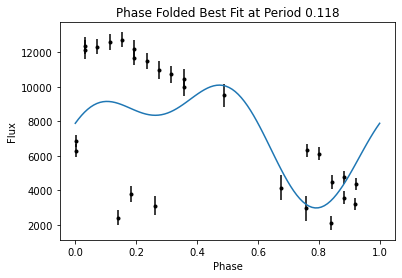

8312233.546284376
PERIOD:  0.1509889811277389


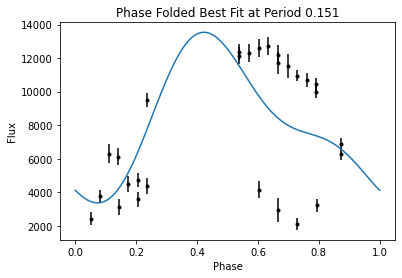

8802718.972613575
PERIOD:  0.1311819404363632


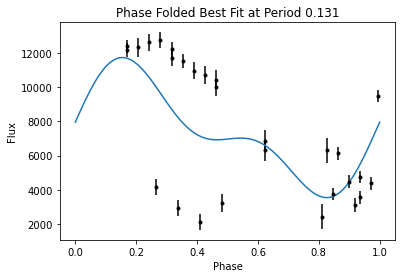

8145826.917182404
PERIOD:  0.2959805727005005


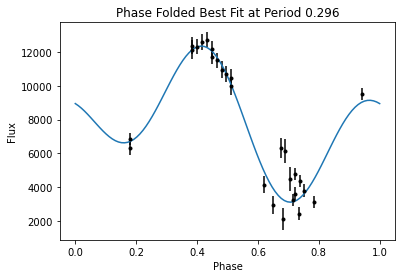

1016301.0921401196
PERIOD:  0.211233377456665


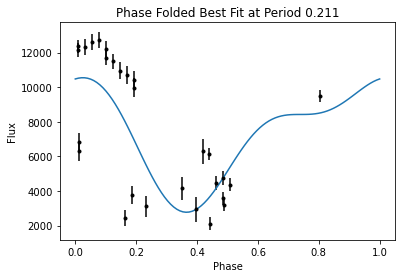

6136657.087869027
PERIOD:  0.2517052888870239


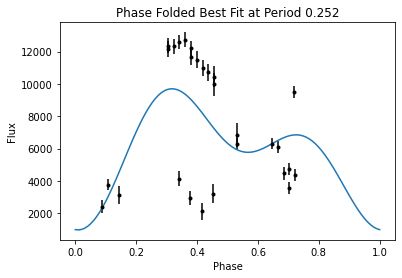

9187276.796616986
88
STARTING FIT FOR BAND: i
PERIOD:  0.0802226960659027


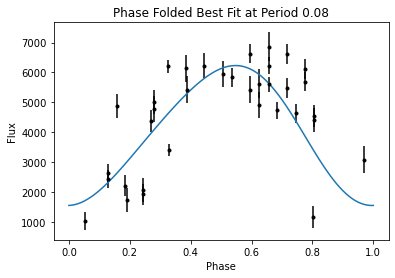

1243659.1455979801
PERIOD:  3.124023914337158


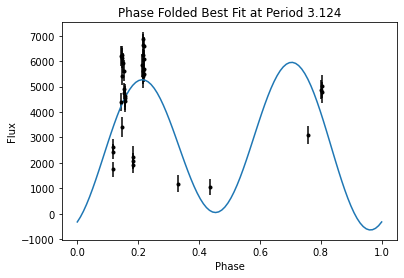

1895792.6277982167
PERIOD:  0.0781304910778999


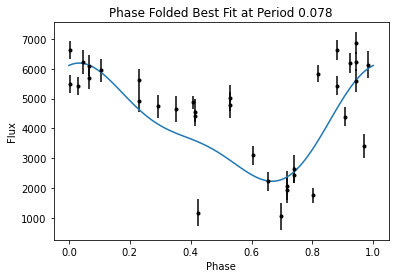

1194891.7785115663
PERIOD:  0.105617806315422


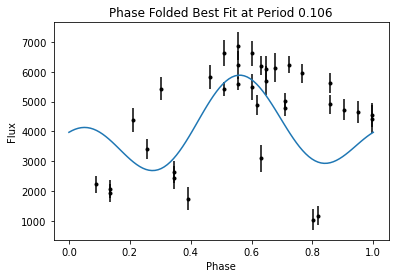

1941676.8643815606
PERIOD:  0.377943217754364


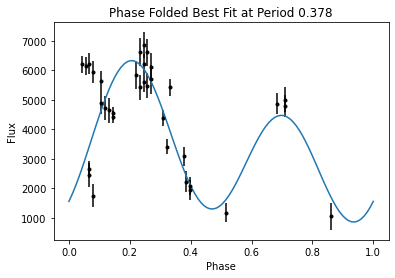

1444893.5948936765
PERIOD:  0.2471027374267578


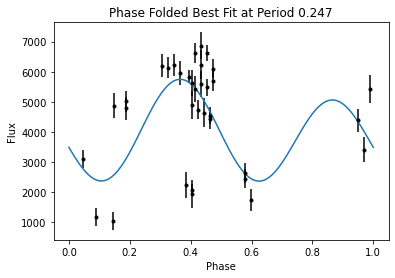

2074229.3249275694
PERIOD:  0.2026383578777313


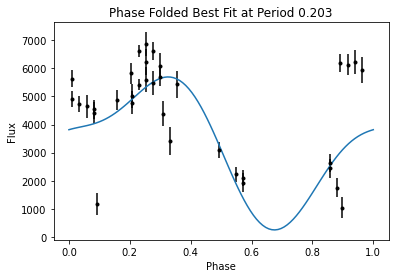

1709327.4259740922
PERIOD:  0.0781134068965911


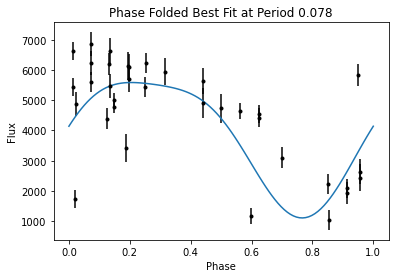

1445928.175174486
PERIOD:  0.2119497209787368


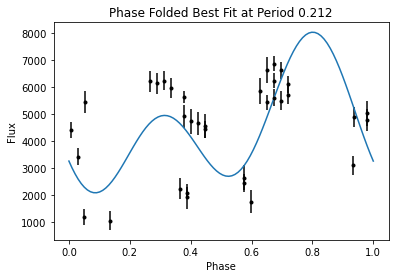

1853652.874469675
PERIOD:  0.2119463976581632


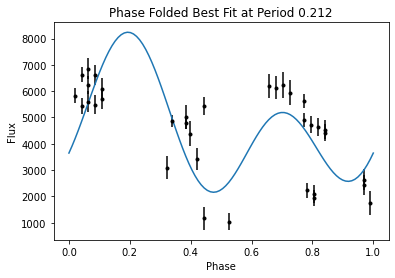

1727657.6723395206
PERIOD:  0.1587326824665069


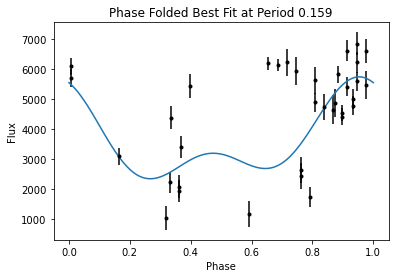

2014658.235542858
PERIOD:  0.1979315532945085


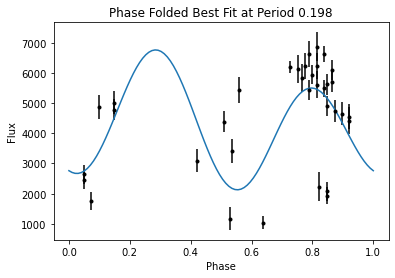

1971903.209245136
PERIOD:  0.1258526444435119


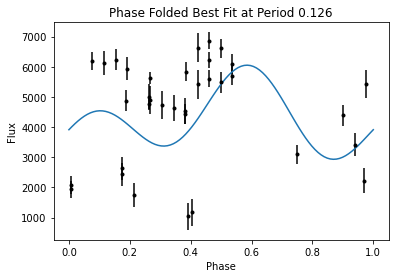

2359529.4383913255
PERIOD:  0.1562255918979644


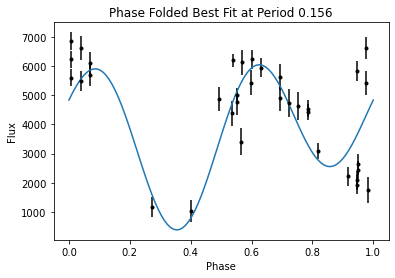

1338651.247934566
PERIOD:  0.1181302840715888


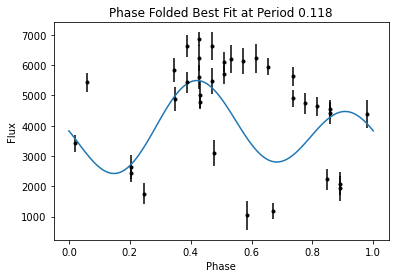

2388229.4343723315
PERIOD:  0.1509889811277389


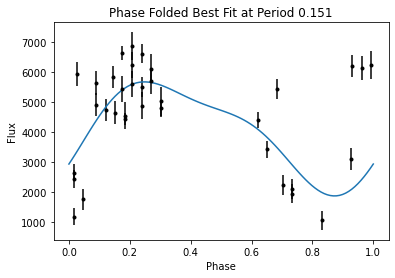

2132053.0697745113
PERIOD:  0.1311819404363632


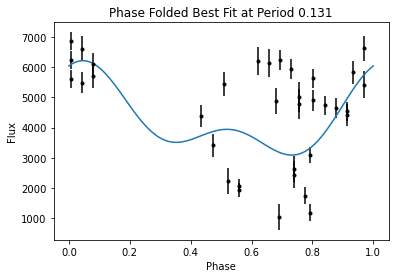

2123783.2384211193
PERIOD:  0.2959805727005005


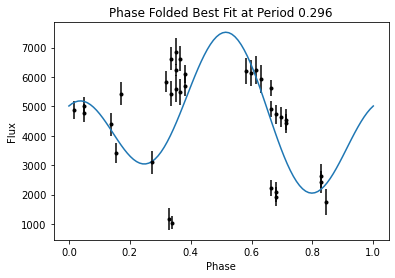

1939461.7083554426
PERIOD:  0.211233377456665


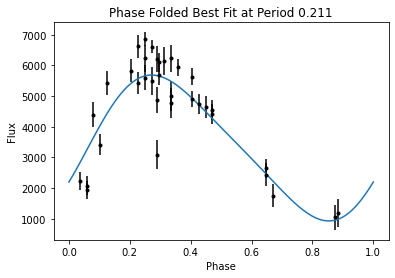

572859.6042549607
PERIOD:  0.2517052888870239


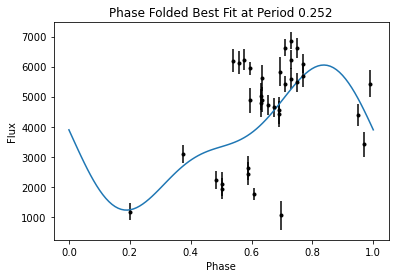

1911562.2669953236
88
STARTING FIT FOR BAND: z
PERIOD:  0.0802226960659027


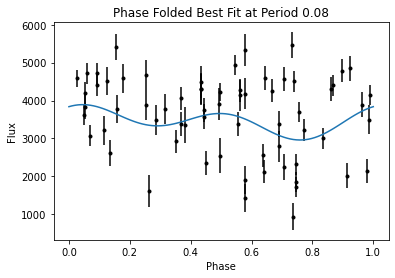

1028753.3152042257
PERIOD:  3.124023914337158


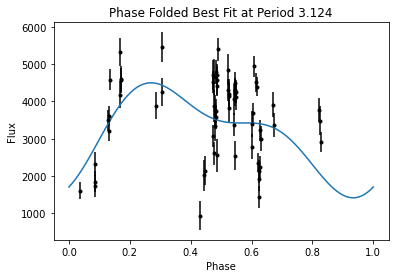

971432.6006240728
PERIOD:  0.0781304910778999


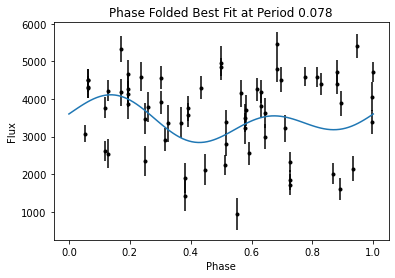

1041138.2758989695
PERIOD:  0.105617806315422


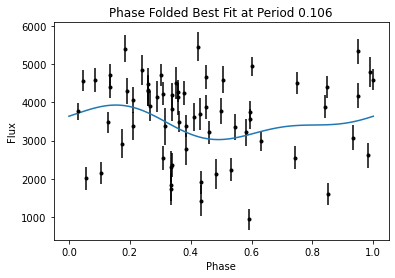

1040260.0837446989
PERIOD:  0.377943217754364


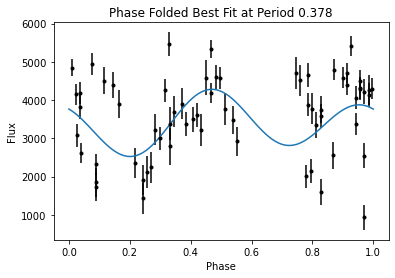

967410.6463425886
PERIOD:  0.2471027374267578


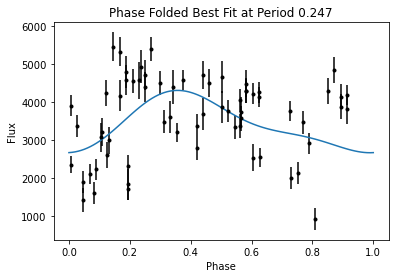

965676.7442416344
PERIOD:  0.2026383578777313


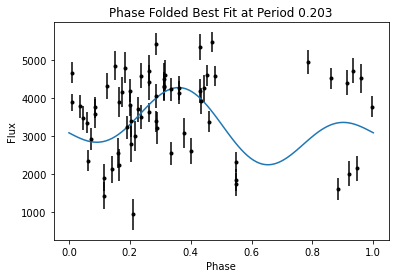

981679.7922486727
PERIOD:  0.0781134068965911


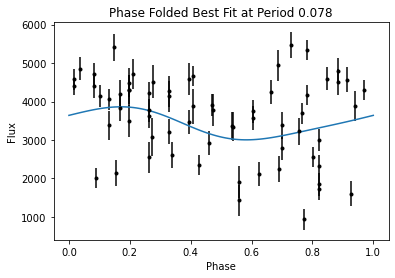

1012265.2374117388
PERIOD:  0.2119497209787368


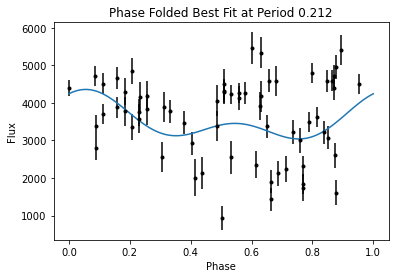

998963.4934023559
PERIOD:  0.2119463976581632


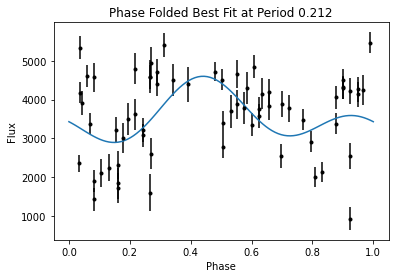

949599.552105033
PERIOD:  0.1587326824665069


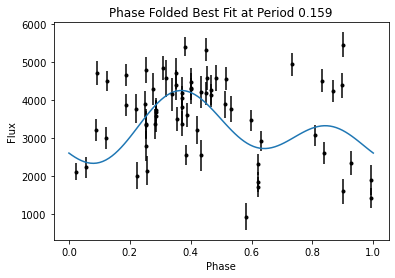

941779.7434672879
PERIOD:  0.1979315532945085


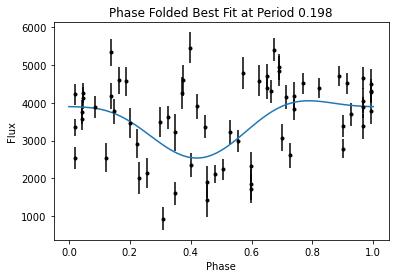

920319.2547582977
PERIOD:  0.1258526444435119


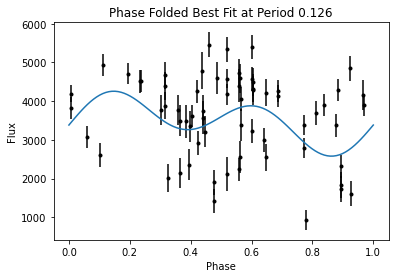

983037.9081598133
PERIOD:  0.1562255918979644


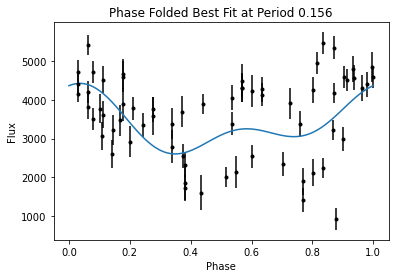

851827.0967058326
PERIOD:  0.1181302840715888


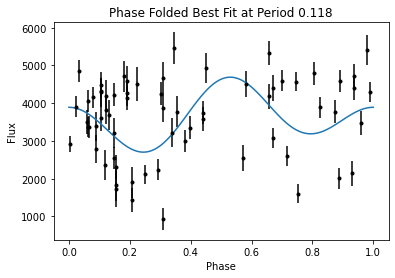

1071031.0537104707
PERIOD:  0.1509889811277389


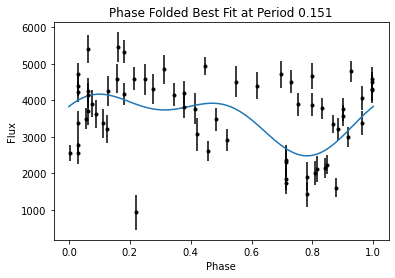

908089.7211944896
PERIOD:  0.1311819404363632


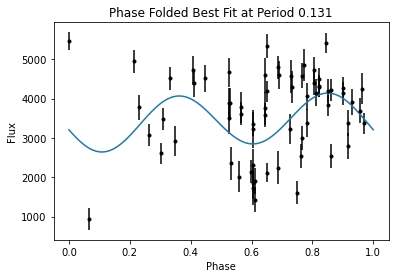

952729.8669261035
PERIOD:  0.2959805727005005


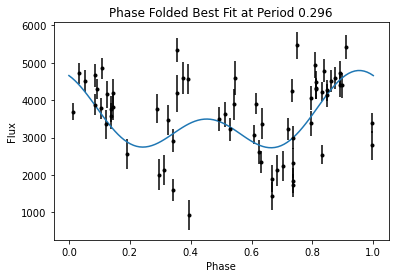

813178.1479390207
PERIOD:  0.211233377456665


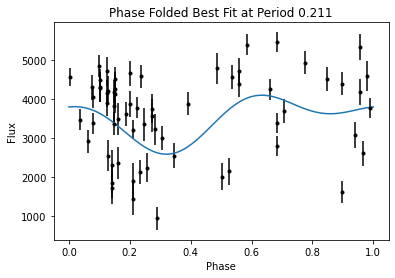

947112.6770512735
PERIOD:  0.2517052888870239


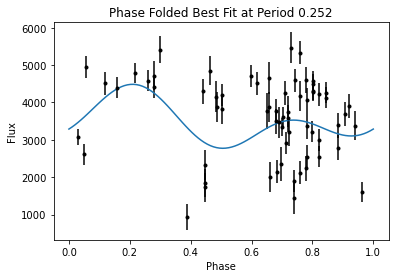

1038157.2296036617


In [23]:
"""
CHECKING FOR PHASE FOLDING ALL PERIODS AT EACH BAND
"""

# Finding all signals with FAPs less than 0.001 in the g band

def get_band_ts(df, band):
    return df[band + " BJD"], df[band + " Flux"], df[band + " dy"]

bands = ["g", "r", "i", "z"]
# df = pd.read_csv("data/DC21zaoi.csv")
periods = np.array(periods)
print(periods)
for band in bands:
    # band = "r"
    tg, fg, dg = get_band_ts(df, band)
    print(len(tg))
    tg = tg.dropna()
    fg = fg.dropna()
    dg = dg.dropna()

    lsg = LombScargle(tg, fg, dg, nterms=2)
    frequency, power = lsg.autopower(minimum_frequency=0.001, maximum_frequency=50, samples_per_peak=15)
    #freqg, pg = lsg.autopower(minimum_frequency=0.05, maximum_frequency=0.2, samples_per_peak=15)
    power = abs(power)
    
    
    print("STARTING FIT FOR BAND: " + band)
    for p in periods:
        fit_peaks(p, tg, fg, dg, lsg)
        
    
    
    
    

In [ ]:
"""
Find the FAP for each of the major peaks. 
Then, compute the mean FAP and show the signal with the lowest mean FAPs
"""


def get_band_ts(df, band):
    return df[band + " BJD"], df[band + " Flux"], df[band + " dy"]

bands = ["g", "r", "i", "z"]
df = pd.read_csv("data/DC22erqsq.csv")

periods = [0.6453082759220174, 0.21954700125452684, 0.2647498899909206, 0.28950483246532827, 
           0.18491172513011217, 0.22675354712842896, 2.698277420351543, 0.5761857638328277]

# periods = [0.6453082759220174, 0.21954700125452684]
faps = []
for p in periods:
    print("STARTING FAP CALCULATION FOR PERIOD: " + str(p))
    fap = []
    for band in bands[1:]:
        # band = "r"
        tg, fg, dg = get_band_ts(df, band)
        tg = tg.dropna()
        fg = fg.dropna()
        dg = dg.dropna()

        lsg = LombScargle(tg, fg, dg)
        frequency, power = lsg.autopower(minimum_frequency=0.001, maximum_frequency=50, samples_per_peak=15)
        #freqg, pg = lsg.autopower(minimum_frequency=0.05, maximum_frequency=0.2, samples_per_peak=15)
        power = abs(power)

        
            # fit_peaks(p, tg, fg, lsg)
        fap.append(lsg.false_alarm_probability(lsg.power(1/p)))
        
    faps.append(np.mean(fap))
    print(fap)
    
print(faps)   

In [ ]:
"""
Probe near the 0.22 day signal to see if there is a signal with lower mean FAP
"""
mean_fap = 1
per = 0
pers = np.linspace(periods[1]-0.01, periods[1]+0.01, 500)

for p in pers:
    print("Period: " + str(p))
    fap = []
    for band in bands:
        # band = "r"
        tg, fg, dg = get_band_ts(df, band)
        tg = tg.dropna()
        fg = fg.dropna()
        dg = dg.dropna()

        lsg = LombScargle(tg, fg, dg)
        frequency, power = lsg.autopower(minimum_frequency=0.001, maximum_frequency=50, samples_per_peak=15)
        #freqg, pg = lsg.autopower(minimum_frequency=0.05, maximum_frequency=0.2, samples_per_peak=15)
        power = abs(power)

        
            # fit_peaks(p, tg, fg, lsg)
        fap.append(lsg.false_alarm_probability(lsg.power(1/p)))
    
    # print(np.mean(fap))
    if np.mean(fap) < mean_fap:
        mean_fap = np.mean(fap)
        per = p
        
print(mean_fap, per)

In [ ]:
"""
CHECKING FOR PHASE FOLDING ALL PERIODS AT EACH BAND
"""

# Finding all signals with FAPs less than 0.001 in the g band

def get_band_ts(df, band):
    return df[band + " BJD"], df[band + " Flux"], df[band + " dy"]

bands = ["g", "r", "i", "z"]
df = pd.read_csv("data/DC21zaoi.csv")

# periods = [0.6453082759220174, 0.21954700125452684, 0.2647498899909206, 0.28950483246532827, 
#            0.18491172513011217, 0.22675354712842896, 2.698277420351543, 0.5761857638328277]

periods = [0.6453082759220174, 0.21954700125452684]

for band in bands:
    # band = "r"
    tg, fg, dg = get_band_ts(df, band)
    print(len(tg))
    tg = tg.dropna()
    fg = fg.dropna()
    dg = dg.dropna()

    lsg = LombScargle(tg, fg, dg)
    frequency, power = lsg.autopower(minimum_frequency=0.001, maximum_frequency=50, samples_per_peak=15)
    #freqg, pg = lsg.autopower(minimum_frequency=0.05, maximum_frequency=0.2, samples_per_peak=15)
    power = abs(power)
    
    
    print("STARTING FIT FOR BAND: " + band)
    fit_peaks(periods[1], tg, fg, lsg)
    

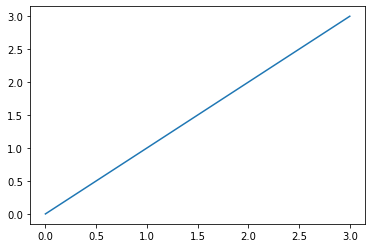

In [3]:
import matplotlib.pyplot as plt
plt.plot([0,1,2,3], [0,1,2,3])